# Slightly Less Toy Problem Optimization

This notebook explores what happens when you take the two-link rope toy problem and pull the rope to the right

In [107]:
import notebook_finder
import os
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=3)
import scipy.optimize as optimize
import toy_problem_optimization_common as tpo
from toy_problem_optimization_common import BOLD
from IPython.display import HTML

### Define goal

Our goal will be denoted as $g$, for now we simply assume its defined in the full state space

In [98]:
g = np.array([[5], [0], [6], [0]])
dt = 0.01

# Load Gazebo Data

In [99]:
drag_data = tpo.load_gazebo_data("/home/pmitrano/catkin_ws/src/link_bot/link_bot_teleop/data/0_80_pull_1.txt", g)

In [100]:
HTML('<img src="media/research/0_80_pull_1.gif">')

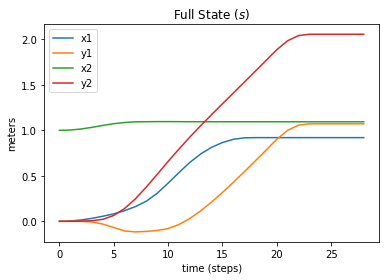

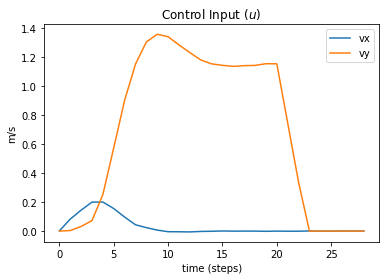

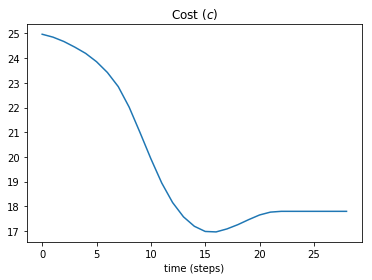

In [101]:
tpo.plot_gz_data(drag_data)

### How well do Random Parameters Do (on average)

In [6]:
N = 1000
costs = np.zeros(N)
model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=2, L=2)
for i in range(N):
    random_params = np.random.randn(model.size())
    model.from_params(random_params)
    costs[i] = tpo.state_prediction_objective(model, g, drag_data, dt)
print("Median cost for random parameters {:.3f}".format(np.median(costs)))

Median cost for random parameters 814.414


### X Model

In [7]:
x_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
x_model.from_params([1, 0, 0, 0, 0, 1, 0, 1])
BOLD("X Model Loss:")
x_eval = tpo.eval_model(x_model, drag_data, g, dt, print_model=False)

**X Model Loss:**

Loss Components:
	current cost: 0.397837916268845
	predict next latent state: 0.0024872387730658124
	predict next cost: 0.6312001370623005
	regularization: 1.7320508075688774e-05
Complete Losses:
	predict next latent state and current cost: 0.2001798980290311
	predict next cost and current cost: 0.5145363471736485


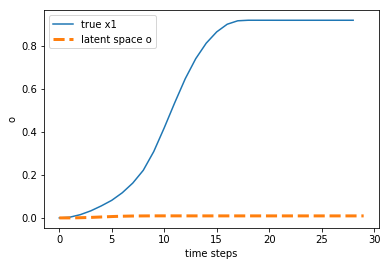

In [8]:
s0 = np.array([[0], [0], [1], [0]])
tpo.plot_x_rollout(x_model, drag_data, dt, s0, g);

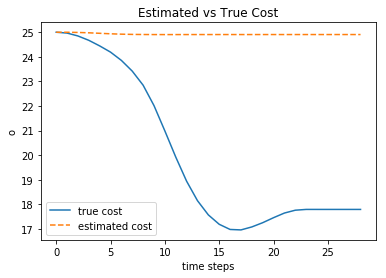

In [9]:
tpo.plot_cost(x_model, drag_data, dt, g)

### Optimize CSP On Drag Data

In [51]:
csp_drag_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=2, L=2)
BOLD("CSP Drag Model Loss:")
csp_drag_eval = tpo.train_and_eval(csp_drag_model, drag_data, g, dt, tpo.state_prediction_objective)

**CSP Drag Model Loss:**

Finished in 36 iterations
Loss Components:
	current cost: 0.0008737925658614762
	predict next latent state: 0.0010523125259784083
	predict next cost: 0.05280213484955322
	regularization: 0.00026846460838060793
Complete Losses:
	predict next latent state and current cost: 0.0012315171543005503
	predict next cost and current cost: 0.027106428316087956
Model reduction Matrix: [[-0.17 -0.28  0.42 -1.58]
 [-1.1  -0.32  0.45 -1.3 ]]
Dynamics Matrices: [[-2.17  1.8 ]] , [[ -0.15 -17.93]
 [ -0.72 -19.47]]
Cost Matrix: [[ 1.04 -0.65]
 [-1.54  1.39]]


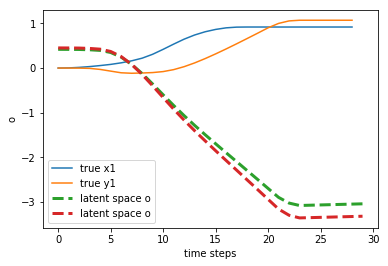

In [52]:
s0 = np.array([[0], [0], [1], [0]])
tpo.plot_xy_rollout(csp_drag_model, drag_data, dt, s0, g);

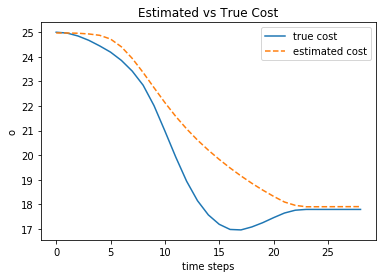

In [53]:
tpo.plot_cost(csp_drag_model, drag_data, dt, g)

### Optimize CCP On Drag Data

In [54]:
ccp_drag_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=2, L=2)
BOLD("CCP Drag Model Loss:")
ccp_drag_eval = tpo.train_and_eval(ccp_drag_model, drag_data, g, dt, tpo.state_prediction_objective)

**CCP Drag Model Loss:**

Finished in 58 iterations
Loss Components:
	current cost: 0.0033817259672452
	predict next latent state: 0.004592800543702283
	predict next cost: 0.03212950991259383
	regularization: 0.00015032504191021944
Complete Losses:
	predict next latent state and current cost: 0.004137588297383961
	predict next cost and current cost: 0.017905942981829733
Model reduction Matrix: [[-0.74  0.87 -2.07  1.14]
 [-1.99  0.47 -1.17  0.84]]
Dynamics Matrices: [[ 4.18 -2.93]] , [[-0.55 13.11]
 [-0.2   2.87]]
Cost Matrix: [[ 0.82 -2.09]
 [ 0.29  1.05]]


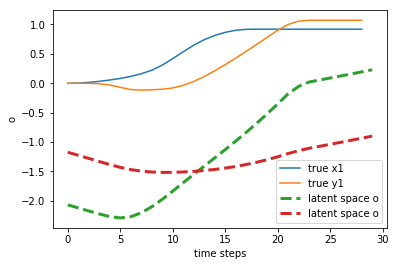

In [55]:
s0 = np.array([[0], [0], [1], [0]])
tpo.plot_xy_rollout(ccp_drag_model, drag_data, dt, s0, g);

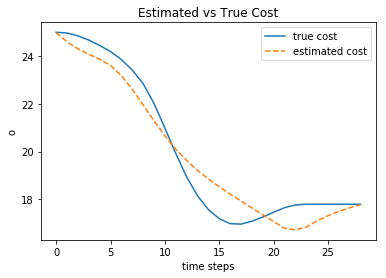

In [96]:
tpo.plot_cost(ccp_drag_model, drag_data, dt, g)

# Load and Eval Various Gazebo Simulations

In [143]:
def load_gz_train_and_eval(experiment, seed=0):
    np.random.seed(seed)
    data = tpo.load_gazebo_data("/home/pmitrano/catkin_ws/src/link_bot/link_bot_teleop/data/" + experiment, g)
    ccp_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=2, L=2)
    p = np.random.randn(ccp_model.size())
    ccp_eval = tpo.train_and_eval(ccp_model, data, g, dt, tpo.one_step_cost_prediction_objective, initial_params=p)
    s0 = data[0][0]
    tpo.plot_xy_rollout(ccp_model, data, dt, s0, g);
    tpo.plot_cost(ccp_model, data, dt, g)

In [144]:
experiments = os.listdir("/home/pmitrano/catkin_ws/src/link_bot/link_bot_teleop/data/")
print(experiments)

['fwd_1.txt', '0_80_pull_1.txt']


Finished in 34 iterations
Loss Components:
	current cost: 0.044986963911994506
	predict next latent state: 0.12698200097224543
	predict next cost: 0.010250209916875513
	regularization: 0.0001683375880044952
Complete Losses:
	predict next latent state and current cost: 0.08615282003012446
	predict next cost and current cost: 0.027786924502439504
Model reduction Matrix: [[-0.043 -1.895  0.852  1.894]
 [-0.234  2.059  0.942 -3.24 ]]
Dynamics Matrices: [[0.662 0.715]] , [[-5.724  0.975]
 [-2.055 14.782]]
Cost Matrix: [[ 0.106  0.317]
 [ 1.494 -0.217]]


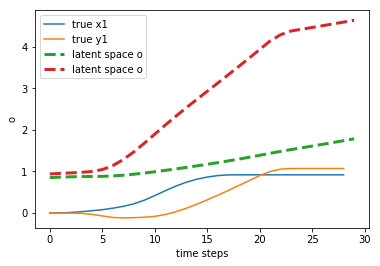

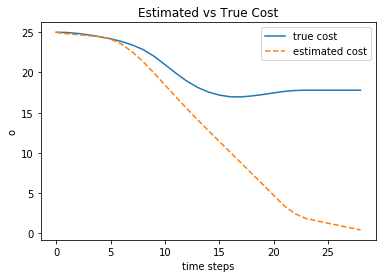

In [145]:
load_gz_train_and_eval(experiments[1])

Finished in 58 iterations
Loss Components:
	current cost: 0.9720683740718604
	predict next latent state: 3.268558867317122e-06
	predict next cost: 0.15073171309177855
	regularization: 0.08798297871820372
Complete Losses:
	predict next latent state and current cost: 0.5740188000335676
	predict next cost and current cost: 0.6493830223000232
Model reduction Matrix: [[    0.526  1502.182    -0.536 -5597.201]]
Dynamics Matrices: [[0.085]] , [[  -0.219 -674.039]]
Cost Matrix: [[6585.629]]


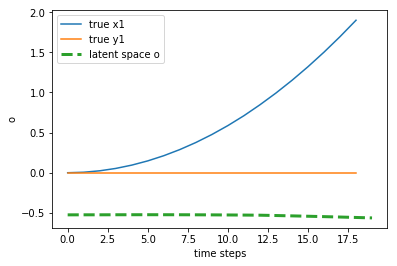

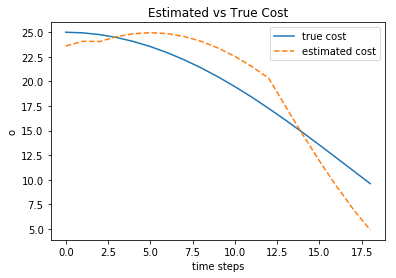

In [139]:
load_gz_train_and_eval(experiments[0])